In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import xgboost as xgb
from collections import defaultdict 
import gc

import matplotlib.pyplot as plt
from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,  GroupKFold, cross_val_score, cross_validate, cross_val_predict
import scikitplot as skplt
from sklearn import utils
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [ ]:
## release memory
#del df_all
#gc.collect()
## read data
train1 = pd.read_hdf('../input/train_online_retail.h5').reset_index(drop=True)
test1 = pd.read_hdf('../input/test_online_retail.h5').reset_index(drop=True)

df_all = pd.concat([train1, test1], sort=False)

## release memory
del train1, test1
gc.collect()


def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['is_canceled', 'is_test', 'canceled','description', 'country','year']
    return [x for x in feats if x not in black_list]

def group_to_dict(group_key, agg_func=np.sum):
    train = df_all[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]
        
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)


In [ ]:
#feature engineering
df_all['cnt_customer_quantity'] = df_all['customer_id'].map(group_to_dict('quantity'))
df_all['cnt_customer_cancel'] = df_all['customer_id'].map(group_to_dict('customer_id'))
df_all['cnt_customer_cancel18'] = df_all['cnt_customer_cancel']<18
df_all['cnt_customer_orders'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.size))

df_all['cnt_product_cancel'] = df_all['stock_code'].map(group_to_dict('customer_id'))
df_all['cnt_product_orders'] = df_all['stock_code'].map(group_to_dict('customer_id', agg_func=np.size))
df_all['cnt_productall_cancel'] = df_all['stock_code'].map(group_to_dict('stock_code'))
df_all['cnt_productall_orders'] = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.size))

df_all['price_productall_cancel'] =df_all['cnt_productall_cancel']* df_all['price_unit']


df_all['Dates'] = pd.to_datetime(df_all['invoice_date'], format='%Y:%M:%D').dt.date
df_all['Hours'] = pd.to_datetime(df_all['invoice_date'], format='%Y:%M:%D').dt.time

df_all.Dates2 = pd.to_datetime(df_all.Dates)
df_all['year'] = df_all.Dates2.dt.year
df_all['month'] = df_all.Dates2.dt.month

df_all['month2']=df_all['month'].astype(int).values
df_all.loc[(df_all['description'] == 'Manual') & (df_all['is_canceled'] >0), 'Manual_canceled'] = 1
df_all.loc[df_all['Manual_canceled'].isnull(), 'Manual_canceled'] = 0
df_all.columns

df_all.loc[(df_all['month'] == 12) | (df_all['month'] == 1), 'Christmas_time'] = 1
df_all.loc[df_all['Christmas_time'].isnull(), 'Christmas_time'] = 0
df_all.columns


df_all.head(50)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,...,cnt_productall_cancel,cnt_productall_orders,price_productall_cancel,Dates,Hours,year,month,month2,Manual_canceled,Christmas_time
0,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,...,1,242.0,5.94922,2009-12-01,09:06:00,2009,12,12,0.0,1.0
1,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,...,11,890.0,59.9414,2009-12-01,09:06:00,2009,12,12,0.0,1.0
2,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,...,11,1081.0,65.4414,2009-12-01,09:06:00,2009,12,12,0.0,1.0
3,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,...,10,1384.0,16.9043,2009-12-01,09:06:00,2009,12,12,0.0,1.0
4,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,...,3,185.0,20.8477,2009-12-01,09:06:00,2009,12,12,0.0,1.0
5,2,17,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-01 09:06:00,1.450195,17.400000,1,United Kingdom,False,...,3,264.0,4.35059,2009-12-01,09:06:00,2009,12,12,0.0,1.0
6,2,18,HEART IVORY TRELLIS LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,...,1,426.0,1.65039,2009-12-01,09:06:00,2009,12,12,0.0,1.0
7,2,19,HEART FILIGREE DOVE LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,...,4,368.0,6.60156,2009-12-01,09:06:00,2009,12,12,0.0,1.0
8,2,20,FULL ENGLISH BREAKFAST PLATE,16,2009-12-01 09:06:00,3.390625,54.240002,1,United Kingdom,False,...,12,320.0,40.6875,2009-12-01,09:06:00,2009,12,12,0.0,1.0
9,2,21,PIZZA PLATE IN BOX,4,2009-12-01 09:06:00,3.750000,15.000000,1,United Kingdom,False,...,5,210.0,18.75,2009-12-01,09:06:00,2009,12,12,0.0,1.0


In [ ]:
# prepare to train
train1 = df_all[ ~df_all['is_canceled'].isnull() ].copy()
test1 = df_all[ df_all['is_canceled'].isnull() ].copy()

In [ ]:
#starter validation
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['is_canceled', 'is_test', 'is_canceled_pred', 'is_canceled_cat', 'month']
    
    return [x for x in feats if x not in black_list]


class CustomCV:
    def __init__(self, groups, index, shuffle=True, n_splits=5, random_state=0):
        self.n_splits = n_splits
        self.groups = groups
        self.shuffle = shuffle
        self.index = index
        self.random_state = random_state

    def split(self, X, y, groups=None):
        if self.shuffle:
            X, y, self.groups, self.index = utils.shuffle(X, y, self.groups, self.index, random_state=self.random_state)

        group_kfold = GroupKFold(n_splits=self.n_splits)

        for train_idx, test_idx in group_kfold.split(X, y, self.groups):    
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test   = X[test_idx], y[test_idx]

            yield train_idx, test_idx 

    def get_index(self):
        return self.index


In [ ]:
def group_and_calc_mse(train):
    train_agg = train.groupby('invoice')[ ['price_total', 'is_canceled_pred', 'is_canceled'] ].sum()

    train_agg['is_canceled'] = train_agg['is_canceled'] > 0
    train_agg['is_canceled_pred'] = train_agg['is_canceled_pred'] > 0

    train_agg['total_return'] = train_agg['price_total'] * train_agg['is_canceled']
    train_agg['total_return_pred'] = train_agg['price_total'] * train_agg['is_canceled_pred']

    return mse( train_agg['total_return'].values,  train_agg['total_return_pred'].values)

def update_test_fold(y_pred, df, index_map, test_idx, pred_feat='is_canceled_pred'):
    sel_index = df.index.isin( index_map[test_idx] )
    df.loc[ sel_index, [pred_feat]] = y_pred

def run_cv(train, model_cls, model_params, n_splits=5, shuffle_rows=True, target='is_canceled', is_plot_learning_curve=True, is_plot_confusion_matrix=True, is_plot_feature_importances=True):
    train.fillna(-1, inplace=True)
    test1.fillna(-1, inplace=True)
    feats = get_feats(train)
    print(feats)
    
    X_test1 = test1[feats].astype(int).values
    X = train[feats].values
    y = train[target].astype(int).values
    y_log = np.log(y)
    pred_feature = '{}_pred'.format(target)
    train[pred_feature] = np.nan
    
    cv = CustomCV(train['invoice'], train.index)
    scores = []
    for train_idx, test_idx in cv.split(X, y):    
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test   = X[test_idx], y[test_idx]
        
        model = model_cls(**model_params)
        
        model.fit(X_train, y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        #y_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)
        
        y_log_pred2 = model.predict(X_test1)
        y_pred2 = np.exp(y_log_pred2)
        
        test1['is_canceled']=y_pred2
        score = mse(y[test_idx], y_pred)
        scores.append(score)
        print(np.mean(scores), np.std(scores))
        
        update_test_fold(y_pred, train, cv.get_index(), test_idx)
        
    print('mse: ', group_and_calc_mse(train))
        
    if is_plot_learning_curve:
        title = 'Learning curve: {} {}'.format(model_cls.__name__, model_params)
        cv = CustomCV(train['invoice'], train.index)
        plot_learning_curve(model_cls(**model_params), X, y, title=title, figsize=(15, 5), random_state=0, cv=cv, scoring='recall')
        
    if is_plot_confusion_matrix:
        skplt.metrics.plot_confusion_matrix(train['is_canceled'], train[pred_feature])
    
    if is_plot_feature_importances:
        model = model_cls(**model_params)
        model.fit(X, y)
        perm = PermutationImportance(model, random_state=0).fit(X, y)
        eli5.show_weights(perm, feature_names=feats)
        
    return test1['is_canceled']


['invoice', 'stock_code', 'quantity', 'price_unit', 'price_total', 'customer_id', 'cnt_customer_cancel18', 'cnt_customer_orders', 'cnt_product_orders', 'cnt_productall_orders', 'price_productall_cancel', 'year', 'month2', 'Manual_canceled', 'Christmas_time']


/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


0.012919474377337089 0.0
0.013054052235434349 0.0001345778580972611
0.013127792171003733 0.0001514902289112559
0.013308854087110031 0.00033994443587730616
0.013342511423646574 0.0003114177913962023
mse:  1871681.6


0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
547224    0.0
547225    1.0
547226    0.0
547227    0.0
547228    0.0
Name: is_canceled, Length: 547229, dtype: float64

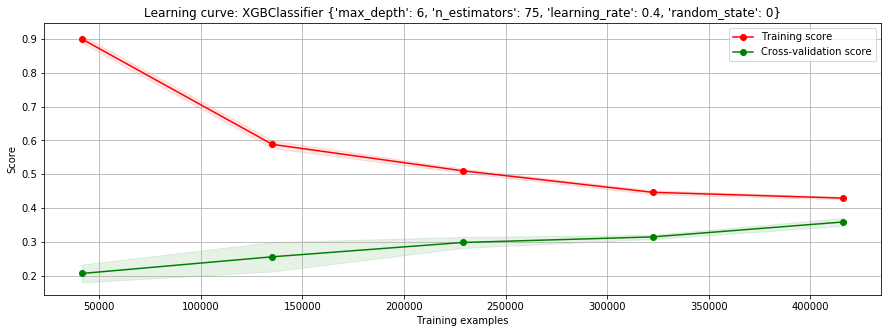

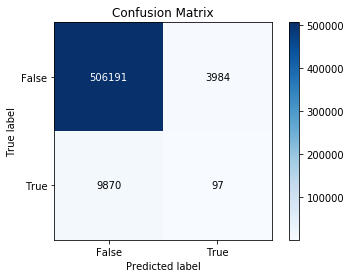

In [ ]:
## create a model
xgb_params = {'max_depth': 6, 'n_estimators': 75, 'learning_rate': 0.4, 'random_state': 0}
run_cv(train1, xgb.XGBClassifier, xgb_params)

In [ ]:
#prepare submit
test1['total_return'] = test1['price_total'] * test1['is_canceled']
result = test1.groupby('invoice')['total_return'].agg(np.sum).to_frame().reset_index()

result[ ['invoice', 'total_return'] ].to_csv('../output/k1.csv', index=False)